# This notebook details how to perform an MRI Simulation and add Noise

In [1]:
import numpy as np
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dipy.sims.voxel import (multi_tensor_dki, single_tensor)
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import (decompose_tensor, from_lower_triangular)

In [3]:
def get_MRI_baseline():
    fimg, fbvals, fbvecs = get_fnames('small_64D')
    bvals, bvecs = read_bvals_bvecs(fbvals, fbvecs)
    bvals = np.concatenate((bvals, bvals * 2), axis=0)
    bvecs = np.concatenate((bvecs, bvecs), axis=0)
    gtab = gradient_table(bvals, bvecs)
    eeg= np.array([1.45704796e-06, 1.75558268e-06, 1.55654514e-06, 1.44484317e-06,
       2.11409969e-06, 4.20040075e-06, 3.64490848e-06, 3.12608849e-06,
       1.26340068e-06, 6.83264224e-07])
    n = np.array([np.mean(eeg),np.std(eeg)])
    mevals =np.concatenate((eeg, n), axis=None).reshape(4,3)
    angles = [(90, 0), (90, 0), (20, 0), (20, 0)]
    fie = 0.69  # intra-axonal water fraction
    fractions = [fie*50, (1 - fie)*50, fie*50, (1 - fie)*50]
    signal_dki, dt, kt = multi_tensor_dki(gtab, mevals, S0=200, angles=angles,
                                          fractions=fractions, snr=None)
    signal_noisy, dt, kt = multi_tensor_dki(gtab, mevals, S0=200,
                                            angles=angles, fractions=fractions,
                                            snr=10)
    dt_evals, dt_evecs = decompose_tensor(from_lower_triangular(dt))
    signal_dti = single_tensor(gtab, S0=200, evals=dt_evals, evecs=dt_evecs,
                               snr=None)
    
    signal =np.array([])
    for i in range(1148):
        mevals =np.concatenate((eeg, n), axis=None).reshape(4,3)
        signal_noisy, dt, kt = multi_tensor_dki(gtab, mevals, S0=200,
                                            angles=angles, fractions=fractions,
                                            snr=10)
        signal = np.concatenate((signal, signal_noisy), axis=None)
    signal =np.repeat(signal,20)
    signal=signal.reshape((149240,20))
        
    return signal,signal_dti,signal_dki,signal_noisy

In [4]:
signal,signal_dti,signal_dki,signal_noisy= get_MRI_baseline()

In [5]:
signal_dki.shape,signal_dti.shape

((130,), (130,))

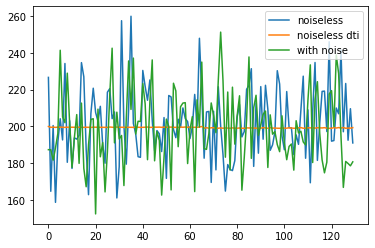

In [6]:
plt.plot(signal[:130,1], label='noiseless')
plt.plot(signal_dti, label='noiseless dti')
plt.plot(signal_noisy, label='with noise')
plt.legend()
plt.show()
